# Hail Risk Prediction using ExtraTreesRegressor

There are many users of online insurance platforms and these companies would like to run analytics on and predict churn based on user activity on the platform. 

**################################################################################<br>
#Licensed Materials - Property of IBM <br>
#(C) Copyright IBM Corp. 2020,2021<br>
#US Government Users Restricted Rights - Use, duplication disclosure restricted<br>
#by GSA ADP Schedule Contract with IBM Corp.<br>
################################################################################**

In this notebook, we will leverage Watson Studio to do the following:

1. Ingest historical hail location, and claim detail
2. Visualize merged dataset and get better understanding of data to build hypotheses for prediction
3. Leverage ExtraTreesRegressor to build regression model that predicts hail claims damage
4. Expose the regression model as RESTful API endpoint for claims analyst and developers

<img src="https://github.com/snyderbrian/Reducing-Severe-Weather-Risk/blob/master/data_science_modelops_team_sport.png?raw=true" width="800" height="500" align="middle"/>

<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Load and visualize hail claim damage data](#load_data)
3. [Prepare data for building regression model](#prepare_data)
4. [Train regression model and test model performance](#build_model)
5. [Save model to ML repository and expose it as REST API endpoint](#save_model)
6. [Summary](#summary)

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

Running the following cell will load all libraries needed to load, visualize, prepare the data and build ML models for our use case

In [1]:
!pip install wget
!pip install brunel

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=27eef3e13aceb79b889a9c5fae09e1d4062bbb295f63490c372abaa5477cc583
  Stored in directory: /tmp/1000690000/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached jupyter_pip-0.3.1-py3-none-any.whl
  Created wheel for brunel: filename=brunel-2.6.2-py3-none-any.whl size=2161207 sha256=1dce1216f9c20e5a4550c338b35780a7afb22a557fa48ba5b55c0b7829aac71c
  Stored in directory: /tmp/1000690000/.cache/pip/wheels/46/da/6e/cb99f128a3078bd9676225bb685f8c2c05a890e436df803c79
Successfully built brunel


In [2]:
import brunel
import pandas as pd
import numpy as np
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
#from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import json
import matplotlib.pyplot as plt
import time
%matplotlib inline

<a id="load_data"></a>
## 2. Load data example
[Top](#top)

Data can be easily loaded using point-and-click functionality. The following illustrates how to load a merged dataset assuming it is called "ClaimsLocationsHail.csv". The file can be located by its name and inserted into the notebook as a **pandas** dataframe aa shown below:

The interface comes up with a generic name, so it is good practice to rename the dataframe to match context of the use case. In this case, we will use **df_claims**.

In [3]:
df_claims = pd.read_csv('/project_data/data_asset/ClaimsLocationsHail.csv')
df_claims.head()

Customer Id  Customer Latitude  Customer Longitude  Customer Zipcode  \
0            1              61.66             -149.33             99654   
1            2              68.84             -148.83               999   
2            3              68.63             -149.60               999   
3            4              70.43             -150.41               999   
4            5              61.18             -149.64               999   

  Customer City Customer State Customer Country  Customer Since  \
0       Wasilla             AK               US            2009   
1        Alaska             AK               US            2013   
2        Alaska             AK               US            2014   
3        Alaska             AK               US            2016   
4        Alaska             AK               US            2016   

   Damage Claim Amount  Hail Inches  
0                  590          0.5  
1                 1387          1.5  
2                 2362          2.0  
3                    7          0.0  
4                 1000          1.0

Data Visualization and Data Audit are key steps in data mining process that helps better understand data before it can be prepared for building ML models

In [4]:
df_claims.dtypes

Customer Id              int64
Customer Latitude      float64
Customer Longitude     float64
Customer Zipcode         int64
Customer City           object
Customer State          object
Customer Country        object
Customer Since           int64
Damage Claim Amount      int64
Hail Inches            float64
dtype: object

In [4]:
df_claims.describe()

Customer Id  Customer Latitude  Customer Longitude  Customer Zipcode  \
count  68583.000000       68583.000000        68583.000000      68583.000000   
mean   34292.380153          38.271156          -95.535287      55864.287331   
std    19798.759232           5.550077           18.368870      32053.359687   
min        1.000000          13.360000         -165.450000          0.000000   
25%    17146.500000          34.180000         -112.010000      28117.000000   
50%    34292.000000          38.890000          -92.020000      59412.000000   
75%    51438.500000          41.920000          -80.350000      85614.000000   
max    68584.000000          72.000000          174.100000      99901.000000   

       Customer Since  Damage Claim Amount   Hail Inches  
count    68583.000000         68583.000000  68583.000000  
mean      2014.268900          1164.145619      0.721137  
std          2.799136          1687.166549      0.736269  
min       1999.000000          -535.000000      0.000000  
25%       2014.000000           157.000000      0.000000  
50%       2015.000000           623.000000      0.500000  
75%       2016.000000          1135.000000      1.250000  
max       2017.000000         12060.000000      2.000000

# Examine Distribution of Data

<Axes: >

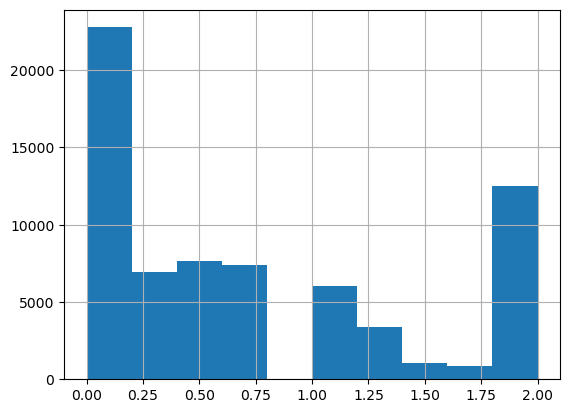

In [5]:
df_claims["Hail Inches"].hist()

<Axes: >

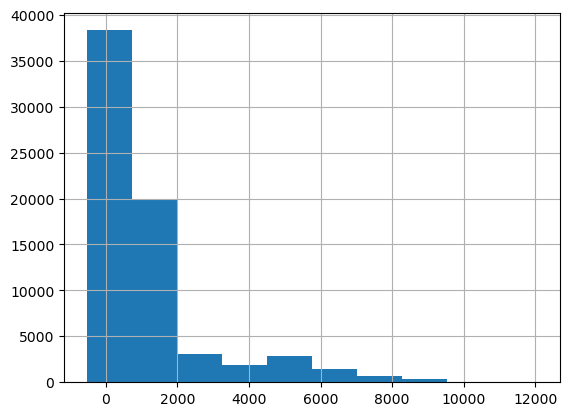

In [6]:
df_claims["Damage Claim Amount"].hist()

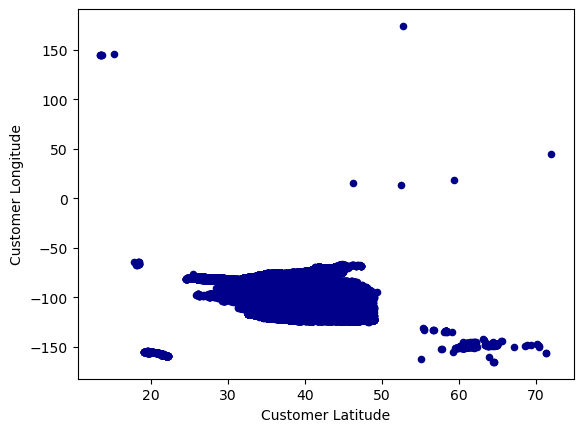

In [7]:
df = df_claims[['Customer Latitude', 'Customer Longitude', 'Customer Id']]
ax1 = df.plot.scatter(x='Customer Latitude',
                      y='Customer Longitude',
                      c='DarkBlue')

# Define the input data to the model

In [8]:
X = df_claims.drop(['Customer Id', 'Customer City', 'Customer State', 'Customer Country', 'Customer Zipcode', 'Damage Claim Amount'], axis=1)

In [9]:
X.shape
X

Customer Latitude  Customer Longitude  Customer Since  Hail Inches
0                  61.66             -149.33            2009          0.5
1                  68.84             -148.83            2013          1.5
2                  68.63             -149.60            2014          2.0
3                  70.43             -150.41            2016          0.0
4                  61.18             -149.64            2016          1.0
...                  ...                 ...             ...          ...
68578              43.54             -110.83            2009          2.0
68579              43.50             -110.88            2015          2.0
68580              43.50             -110.88            2016          0.0
68581              43.75             -105.48            2014          2.0
68582              44.56             -110.40            2014          2.0

[68583 rows x 4 columns]

# Define the target regression variable

In [10]:
y = df_claims['Damage Claim Amount']

# Split the data to training and testing set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Instanitate the ExtraTreesRegressor

In [12]:
reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

# The ExtraTreesRegressor Accuracy score

In [13]:
reg.score(X_test, y_test)

0.9862854997050702

#  Call pipeline.predict() on your X_test data to make a set of test predictions

In [14]:
y_prediction = reg.predict( X_test )

# Show first 10 rows of claim amount predictions

In [15]:
y_prediction[0:10,]

array([1459.  , 4135.74,  144.15,   71.74, 1131.05,  808.88,  555.89,
        442.85,   87.19, 1219.86])

# Test your predictions using sklearn and print the report

In [16]:
report = sklearn.metrics.mean_absolute_error( y_test, y_prediction )
print(report)

72.69386561360875


## User Inputs
The user can specify the name for the space, models and model deployments.
Model and its deployment will be stored in the deployment space. The deployment space can be created programmatically using `ibm-watson-machine-learning` client.
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to True.

In [17]:
# Specify a names for the space being created, the saved model and the model deployment
space_name = 'Severe Weather Risk Deployment Space'

model_name = 'severe_weather_risk_python_model'
model_tag = 'severe_weather_risk_python_model_tag'
model_desc = "Extra Trees Regressor"

deployment_name = 'severe_weather_risk_python_model_deployment'
deployment_tag = 'severe_weather_risk_python_model_deployment_tag'

use_existing_space=True

In [18]:

from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.7"#"4.5"#"3.5"
}

client = APIClient(wml_credentials)



### Create the Deployment Space
Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space.

By default, if the space with specified name already exists, the existing space will be used to store and deploy the models.

In [19]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(5)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Severe Weather Risk Deployment Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().


### Store the Pipeline Details
Store the pipeline in the deployment space. Again, the name for the pipeline is specified in the user inputs cell above. Software specification and default tag for the model are specified in the model metadata.
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model. Available Software specifications can be retrieved using `client.software_specifications.list()`.

In [20]:
client.software_specifications.list(limit=200)

-------------------------------  ------------------------------------  ----  ------------  ------------------------------
NAME                             ID                                    TYPE  STATE         REPLACEMENT
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base  unsupported   runtime-22.2-py3.10
runtime-22.1-r3.6                018ebea5-1d1f-5fec-b93e-5e2ab30e7f38  base  deprecated    runtime-22.2-r4.2
autoai-ts_rt23.1-py3.10          01ce9391-1a79-5a33-94fb-2e134337f314  base  supported
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base  not_provided
tensorflow_rt23.1-py3.10-edt     067048c7-c771-5933-9aa0-4f9fbdc92da8  base  supported
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base  not_provided
tensorflow_rt23.1-py3.10         079a91e0-245f-5269-8926-3c20b28f37dc  base  supported
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base  unsupported   runtime-22.2-py3.10
spa

NAME                                    ID  \
0                     default_py3.6  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9   
1                 runtime-22.1-r3.6  018ebea5-1d1f-5fec-b93e-5e2ab30e7f38   
2           autoai-ts_rt23.1-py3.10  01ce9391-1a79-5a33-94fb-2e134337f314   
3         kernel-spark3.2-scala2.12  020d69ce-7ac1-5e68-ac1a-31189867356a   
4      tensorflow_rt23.1-py3.10-edt  067048c7-c771-5933-9aa0-4f9fbdc92da8   
..                              ...                                   ...   
110        runtime-23.1-py3.10-cuda  f31eb7d1-a784-5a74-a40b-579989aacfcb   
111        tensorflow_rt22.2-py3.10  f65bd165-f057-55de-b5cb-f97cf2c0f393   
112                         do_20.1  f686cdd9-7904-5f9d-a732-01b0d6b10dc5   
113  pytorch-onnx_rt22.2-py3.10-edt  f8a05d07-e7cd-57bb-a10b-23f1d4b837ac   
114            tensorflow_2.4-py3.8  fe185c44-9a99-5425-986b-59bd1d2eda46   

     TYPE         STATE               REPLACEMENT  
0    base   unsupported       runtime-22.2-py3.10  
1    base    deprecated         runtime-22.2-r4.2  
2    base     supported                            
3    base  not_provided                            
4    base     supported                            
..    ...           ...                       ...  
110  base  not_provided                            
111  base     supported                            
112  base     supported                            
113  base     supported                            
114  base   unsupported  tensorflow_rt22.2-py3.10  

[115 rows x 5 columns]

In [21]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.1.1.


In [23]:
sw_spec_uid = client.software_specifications.get_uid_by_name("runtime-23.1-py3.10") 


metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.DESCRIPTION: model_desc,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1",  #"scikit-learn_1.0"
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
    client.repository.ModelMetaNames.TAGS: [model_tag] }


stored_model_details = client.repository.store_model(model=reg, meta_props=metadata, training_data=X_train, training_target=y_train, feature_names=X_train.columns)
stored_model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'Damage Claim Amount',
  'schemas': {'input': [{'fields': [{'name': 'Customer Latitude',
       'type': 'float64'},
      {'name': 'Customer Longitude', 'type': 'float64'},
      {'name': 'Customer Since', 'type': 'int64'},
      {'name': 'Hail Inches', 'type': 'float64'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '336b29df-e0e1-5e7d-b6a5-f6ab722625b2',
   'name': 'runtime-23.1-py3.10'},
  'training_data_references': [{'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'Customer Latitude', 'type': 'float64'},
      {'name': 'Customer Longitude', 'type': 'float64'},
      {'name': 'Customer Since', 'type': 'int64'},
      {'name': 'Hail Inches', 'type': 'float64'}],
     'id': '1',
     'type': 'DataFrame'},
    'type': 'fs'}],
  'type': 'scikit-learn_1.1'},
 'metadata': {'created_at': '2023-07-18T20:40:01.245Z',
  'description': 'Extra Trees Regressor',
  'id':

### Deploy the Model Pipeline
Deploy the saved model. The deployment name is specified in the user inputs cell above. A default tag for the deployment is specified in the deployment metadata.


In [24]:
# deploy the model pipeline
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [ deployment_tag],
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)
deployment_details



#######################################################################################

Synchronous deployment creation for uid: 'fd9ac8d0-736e-42a6-979c-d4b5d4ad6b5a' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='70dfe0be-fbf6-4ae0-a8d5-aa8ca7513f65'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': 'fd9ac8d0-736e-42a6-979c-d4b5d4ad6b5a'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'e7ed1d6c-2e89-42d7-aed5-863b972c1d2b',
   'name': 'S',
   'num_nodes': 1},
  'name': 'severe_weather_risk_python_model_deployment',
  'online': {},
  'space_id': '8ee26bf1-0f38-434e-9c6d-c7a35ce8b754',
  'status': {'online_url': {'url': 'https://internal-nginx-svc.wkc.svc.cluster.local:12443/ml/v4/deployments/70dfe0be-fbf6-4ae0-a8d5-aa8ca7513f65/predictions'},
   'serving_urls': ['https://internal-nginx-svc.wkc.svc.cluster.local:12443/ml/v4/deployments/70dfe0be-fbf6-4ae0-a8d5-aa8ca7513f65/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2023-07-18T20:43:06.320Z',
  'id': '70dfe0be-fbf6-4ae0-a8d5-aa8ca7513f65',
  'modified_at': '2023-07-18T20:43:06.320Z',
  'name': 'severe_weather_risk_python_model_deployment',
  'owner': '1000331044',
  'space_id': '8ee26bf1-0f38-434e-9c6d-c7a35ce8b754',
  'tags': ['severe_weather_risk_pytho

### Sample Scoring
Now we can test the model by scoring a sample record on the deployment as below.

In [25]:

# Select sample customer ids to score
CUSTOMER_IDS=[249,250,310,311]
# Filter these customers records from df_raw
df_score=df_claims[df_claims['Customer Id'].isin(CUSTOMER_IDS)]

In [26]:
# Create a payload with fields and values dictionary
fields=X_train.columns.tolist()
values=df_score[fields].values.tolist()
payload_scoring={"input_data": [{"fields": fields,"values": values}]}
print("Customer ids",CUSTOMER_IDS,"\n\n Predicted Damage Claim Amount:")
#Get the deployment id for the deployed model
deployment_uid=client.deployments.get_uid(deployment_details)


payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}

# Pass the payload to wml client to predict attrition_status for the sample records
scoring_response = client.deployments.score(deployment_uid, payload_scoring)
scoring_response

Customer ids [249, 250, 310, 311] 

 Predicted Damage Claim Amount:


{'predictions': [{'fields': ['prediction'],
   'values': [[13.0], [374.0], [98.0], [102.0]]}]}